In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# === Load Data ===
file_path = "C:/Users/adaml/Downloads/Time Table for Social Science Project.xlsx"

# Load sheets
df_results = pd.read_excel(file_path, sheet_name="results-ChatGPT")
df_personas = pd.read_excel(file_path, sheet_name="Personas")
df_questions = pd.read_excel(file_path, sheet_name="Qestions")


In [ ]:
# === Clean Column Names ===
df_results.columns = df_results.columns.str.strip().str.lower().str.replace(' ', '_')
df_personas.columns = df_personas.columns.str.strip().str.lower().str.replace(' ', '_')
df_questions.columns = df_questions.columns.str.strip().str.lower().str.replace(' ', '_')

# === Parse annotator votes ===
df_results[['ann1', 'ann2', 'ann3']] = df_results["classification_-_don't_fill_now"].astype(str).str.split(';', expand=True)
df_results[['ann1', 'ann2', 'ann3']] = df_results[['ann1', 'ann2', 'ann3']].apply(pd.to_numeric, errors='coerce')

# === Compute majority vote: 2 out of 3 annotators agree ===
df_results['answer'] = (df_results[['ann1', 'ann2', 'ann3']].sum(axis=1) >= 2).astype(int)

# === Drop incomplete entries ===
df_clean = df_results.dropna(subset=['answer'])

# === Merge in religion and solidarity group ===
df_merged = df_clean.merge(df_personas[['id', 'religion']], left_on='persona_id', right_on='id', how='left')
df_merged = df_merged.merge(df_questions[['id', 'solidarity_group']], left_on='question_id', right_on='id', how='left', suffixes=('', '_q'))
df_merged = df_merged.dropna(subset=['solidarity_group'])

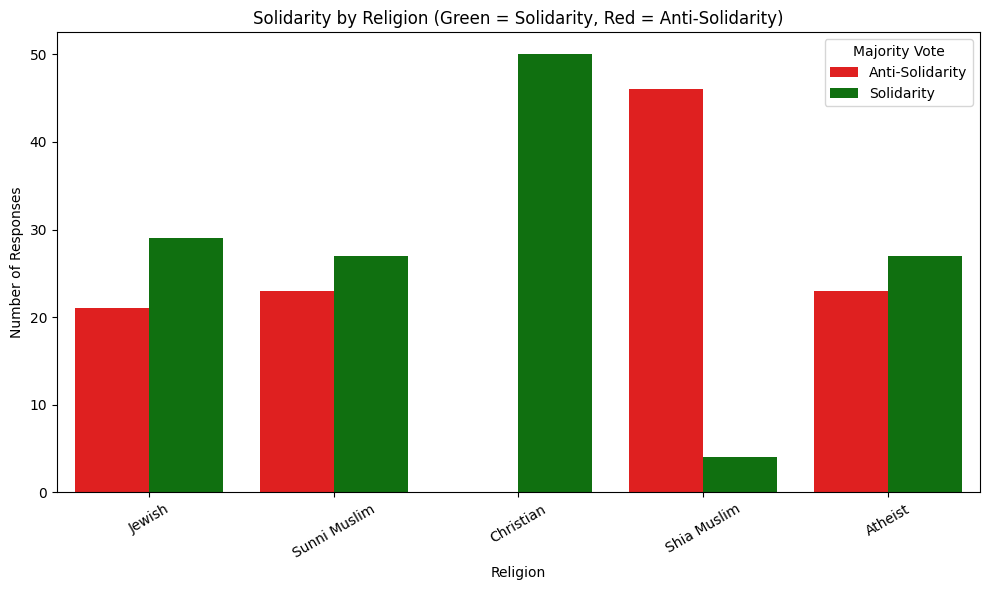

In [13]:
# === Plot 1: Raw Counts by Religion ===
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_merged,
    x='religion',
    hue='answer',
    palette={0: 'red', 1: 'green'}
)
plt.title("Solidarity by Religion (Green = Solidarity, Red = Anti-Solidarity)")
plt.xlabel("Religion")
plt.ylabel("Number of Responses")
plt.legend(title="Majority Vote", labels=["Anti-Solidarity", "Solidarity"])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

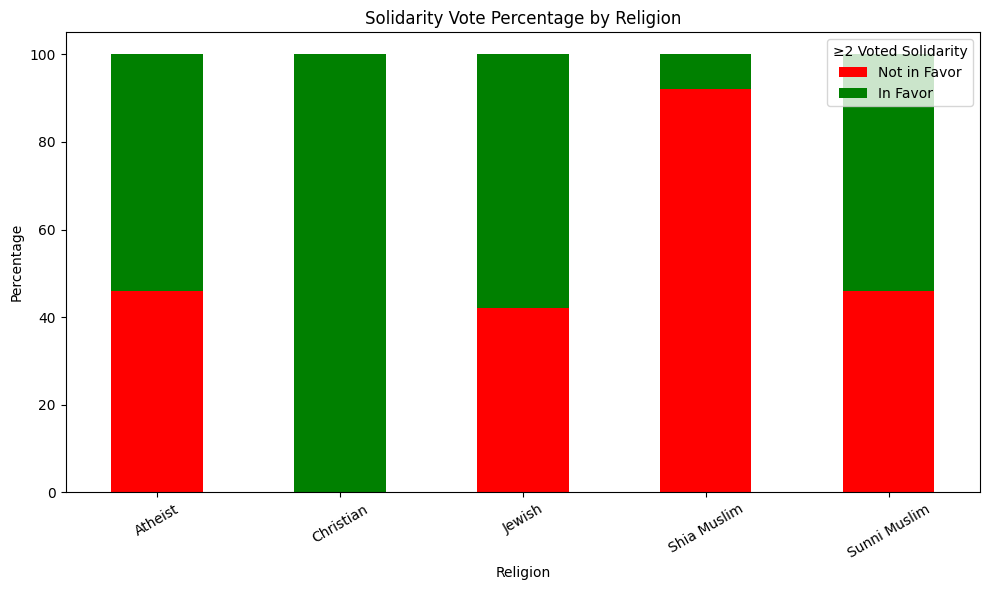

In [ ]:
# === Plot 2: Percentage by Religion ===
# Convert 'answer' to boolean for grouping
df_merged['answer'] = df_merged['answer'].astype(bool)

# Compute normalized percentage
religion_summary = df_merged.groupby(['religion', 'answer']).size().unstack(fill_value=0)
religion_percent = religion_summary.div(religion_summary.sum(axis=1), axis=0) * 100

# Plot percentage chart
religion_percent.plot(
    kind='bar',
    stacked=True,
    color={False: 'red', True: 'green'},
    figsize=(10, 6)
)
plt.title("Solidarity Vote Percentage by Religion")
plt.xlabel("Religion")
plt.ylabel("Percentage")
plt.legend(title="≥2 Voted Solidarity", labels=["Not in Favor", "In Favor"])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

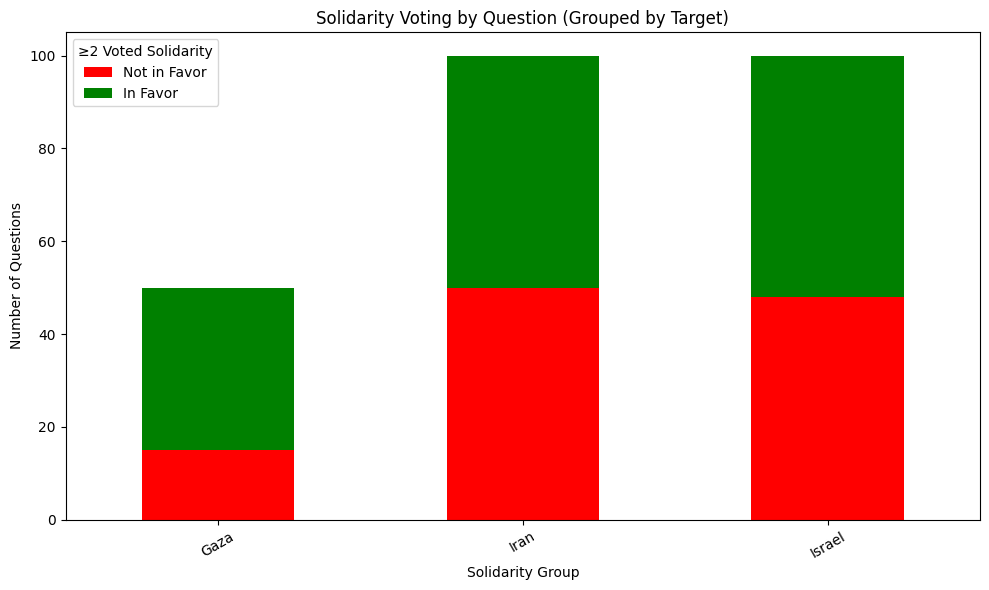

In [10]:
# === Solidarity Support by Target Group (Question-Level Majority) ===

# Parse the classification column (e.g., "1;1;0") into separate votes
df_results[['vote1', 'vote2', 'vote3']] = df_results['classification_-_don\'t_fill_now'].str.split(';', expand=True).astype(float)

# Compute how many votes each response received as "solidarity = 1"
df_results['solidarity_votes'] = df_results[['vote1', 'vote2', 'vote3']].sum(axis=1)

# Merge with question info for solidarity group
df_results = df_results.merge(
    df_questions[['id', 'solidarity_group']],
    left_on='question_id',
    right_on='id',
    how='left',
    suffixes=('', '_q')
)

# Drop if solidarity_group is missing
df_results = df_results.dropna(subset=['solidarity_group'])

# Determine if each question is "In Favor" (≥2 votes for solidarity)
df_results['in_favor'] = df_results['solidarity_votes'] >= 2

# Group by solidarity group and count
group_summary = df_results.groupby(['solidarity_group', 'in_favor']).size().unstack(fill_value=0)

# Optional: Clean group labels (e.g., fix typos)
group_summary.index = group_summary.index.str.strip().str.capitalize()

# Plot
group_summary.plot(kind='bar', stacked=True, color={True: 'green', False: 'red'}, figsize=(10,6))

plt.title("Solidarity Voting by Question (Grouped by Target)")
plt.xlabel("Solidarity Group")
plt.ylabel("Number of Questions")
plt.legend(title="≥2 Voted Solidarity", labels=["Not in Favor", "In Favor"])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


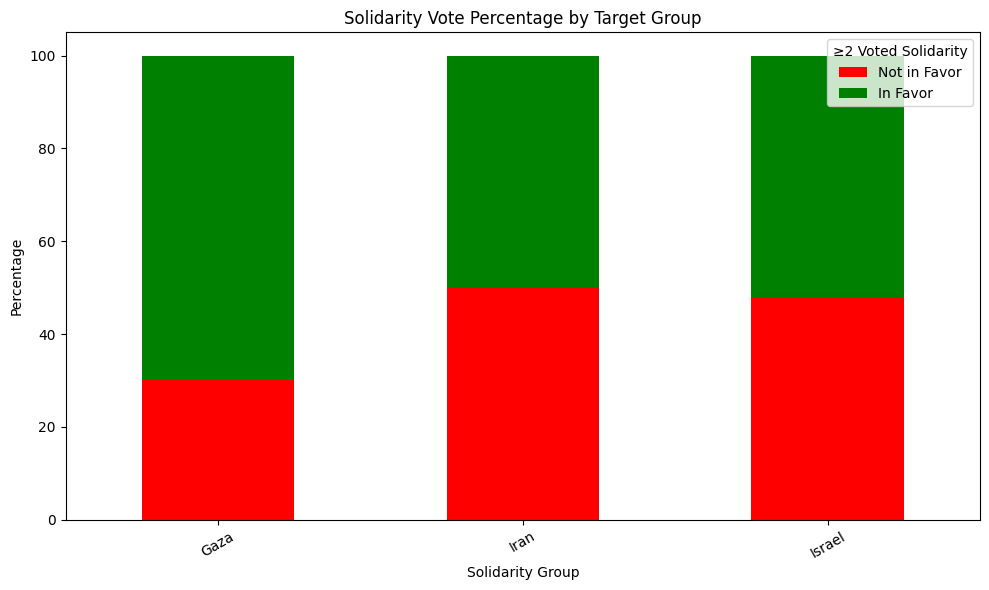

In [11]:
# Compute percentage version
group_percent = group_summary.div(group_summary.sum(axis=1), axis=0) * 100

# Plot percentage
group_percent.plot(
    kind='bar',
    stacked=True,
    color={True: 'green', False: 'red'},
    figsize=(10, 6)
)

plt.title("Solidarity Vote Percentage by Target Group")
plt.xlabel("Solidarity Group")
plt.ylabel("Percentage")
plt.legend(title="≥2 Voted Solidarity", labels=["Not in Favor", "In Favor"])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()